# Exploratory Data Analysis and Visualizations

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from nomination_predictor.config import INTERIM_DATA_DIR

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
    
sns.set_theme(style="whitegrid")
%matplotlib inline


2025-07-15 23:13:02.001 | INFO     | nomination_predictor.config:<module>:103 - Project root: /home/wsl2ubuntuuser/nomination_predictor
2025-07-15 23:13:02.002 | INFO     | nomination_predictor.config:<module>:127 - Configuration loaded


In [ ]:
import pandas as pd

from nomination_predictor.config import INTERIM_DATA_DIR

df = pd.read_csv(INTERIM_DATA_DIR / "feature_engineered.csv")

# Setup and prep explanations

## Seat timeline and vacancy data
When I originally pitched this project I'd planned to analyze the time from a judicial vacancy to nomination, and analyze from vacancy to confirmation.

But until developing a better way to scrape the courts.gov site for vacancy start dates (I got as far as programming these notebooks to scrape from 2009 onwards before deciding to pivot this project's attention to other data sources), our current dataset lacks them.  

So instead of trying to calculate days_vac_to_nom, all timing analysis is based on nomination and confirmation dates instead.

## Failed nominations prior to confirmations

Our data currently contains rows for failed nominations.  It doesn't yet directly chain-link failed nomination(s) together until reaching that seat's next confirmation date.  In theory, now that the FJC data has been merged in, you could make use of their seat_id to look up the seat's history, and for each nomination, see when the next confirmation occurred.  

This makes the assumption that nothing else happened to that seat. Until the other non-CSV-file, messier PDF and HTML sources I've found can be brought into the data-scraping pipeline, the name-driven matching system has only been able to link about 1500 rows between the two data sources we have, much less than either of their totals.  so I don't have high confidence it's capturing _everything_ happening during those interims.

So I chose to hold off work on this until other parts of the project are done, and can come back to it sometime later.  I chose not to do this because I don't know enough about the FJC's Seat ID to know under what circumstances it (or at least the number of seats in any given jurisdiction) could change over time.

## Visualizing missing-data patterns

Some of these columns make sense to be blank (not every judge has 5 degrees and has thee different reappointments on record) so the part we're wanting to reassure ourselves about is that we do have enough data in the columns we care about.

For example, discovering we lack birth days and months & only having years at best for most of the rows is part of what led to the upstream feature-engineering cell using middle-of-year to calculate judge ages as of nominations.

Either of these visualizations is based on a semi-random sampling of the total dataframe (adjusted by the "sample proportion" constant below)

<Axes: >

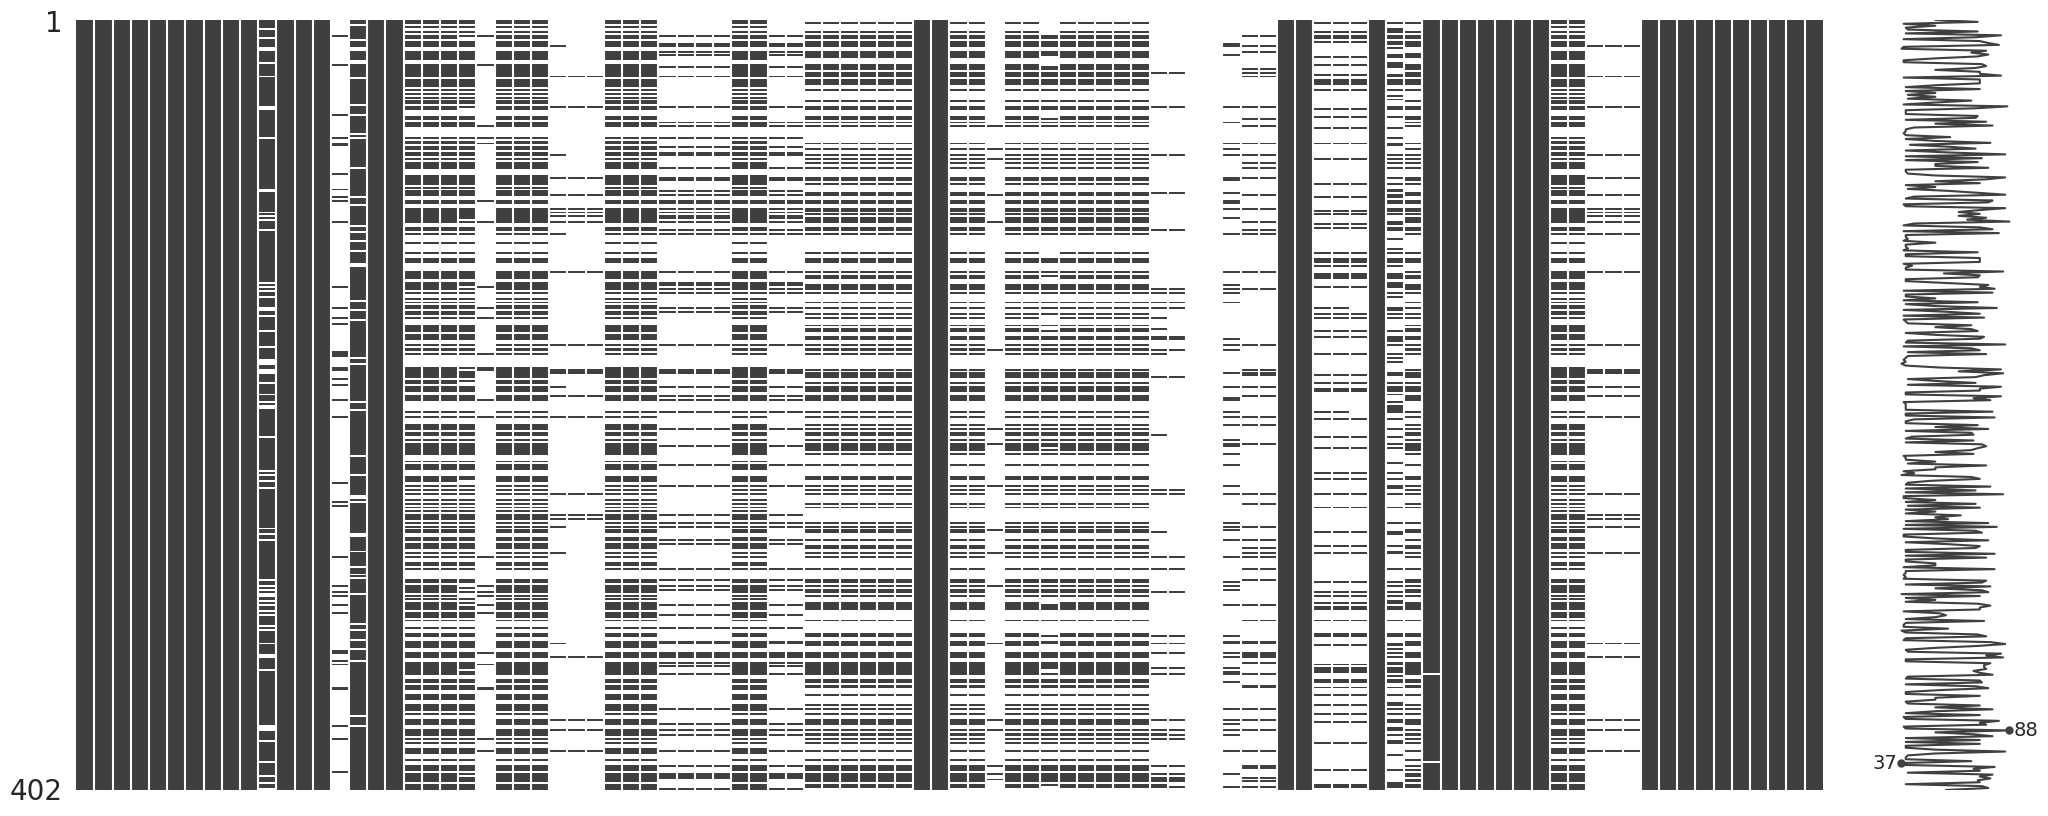

In [ ]:
import missingno as msno

MSNO_SAMPLE_PROPORTION = int(len(df)*0.2)
msno.matrix(df.sample((MSNO_SAMPLE_PROPORTION))) # long-zoom-out-of-spreadsheet-like visualization indicating for a sampling of our dataframe, where there's data vs. where it's absent

<Axes: >

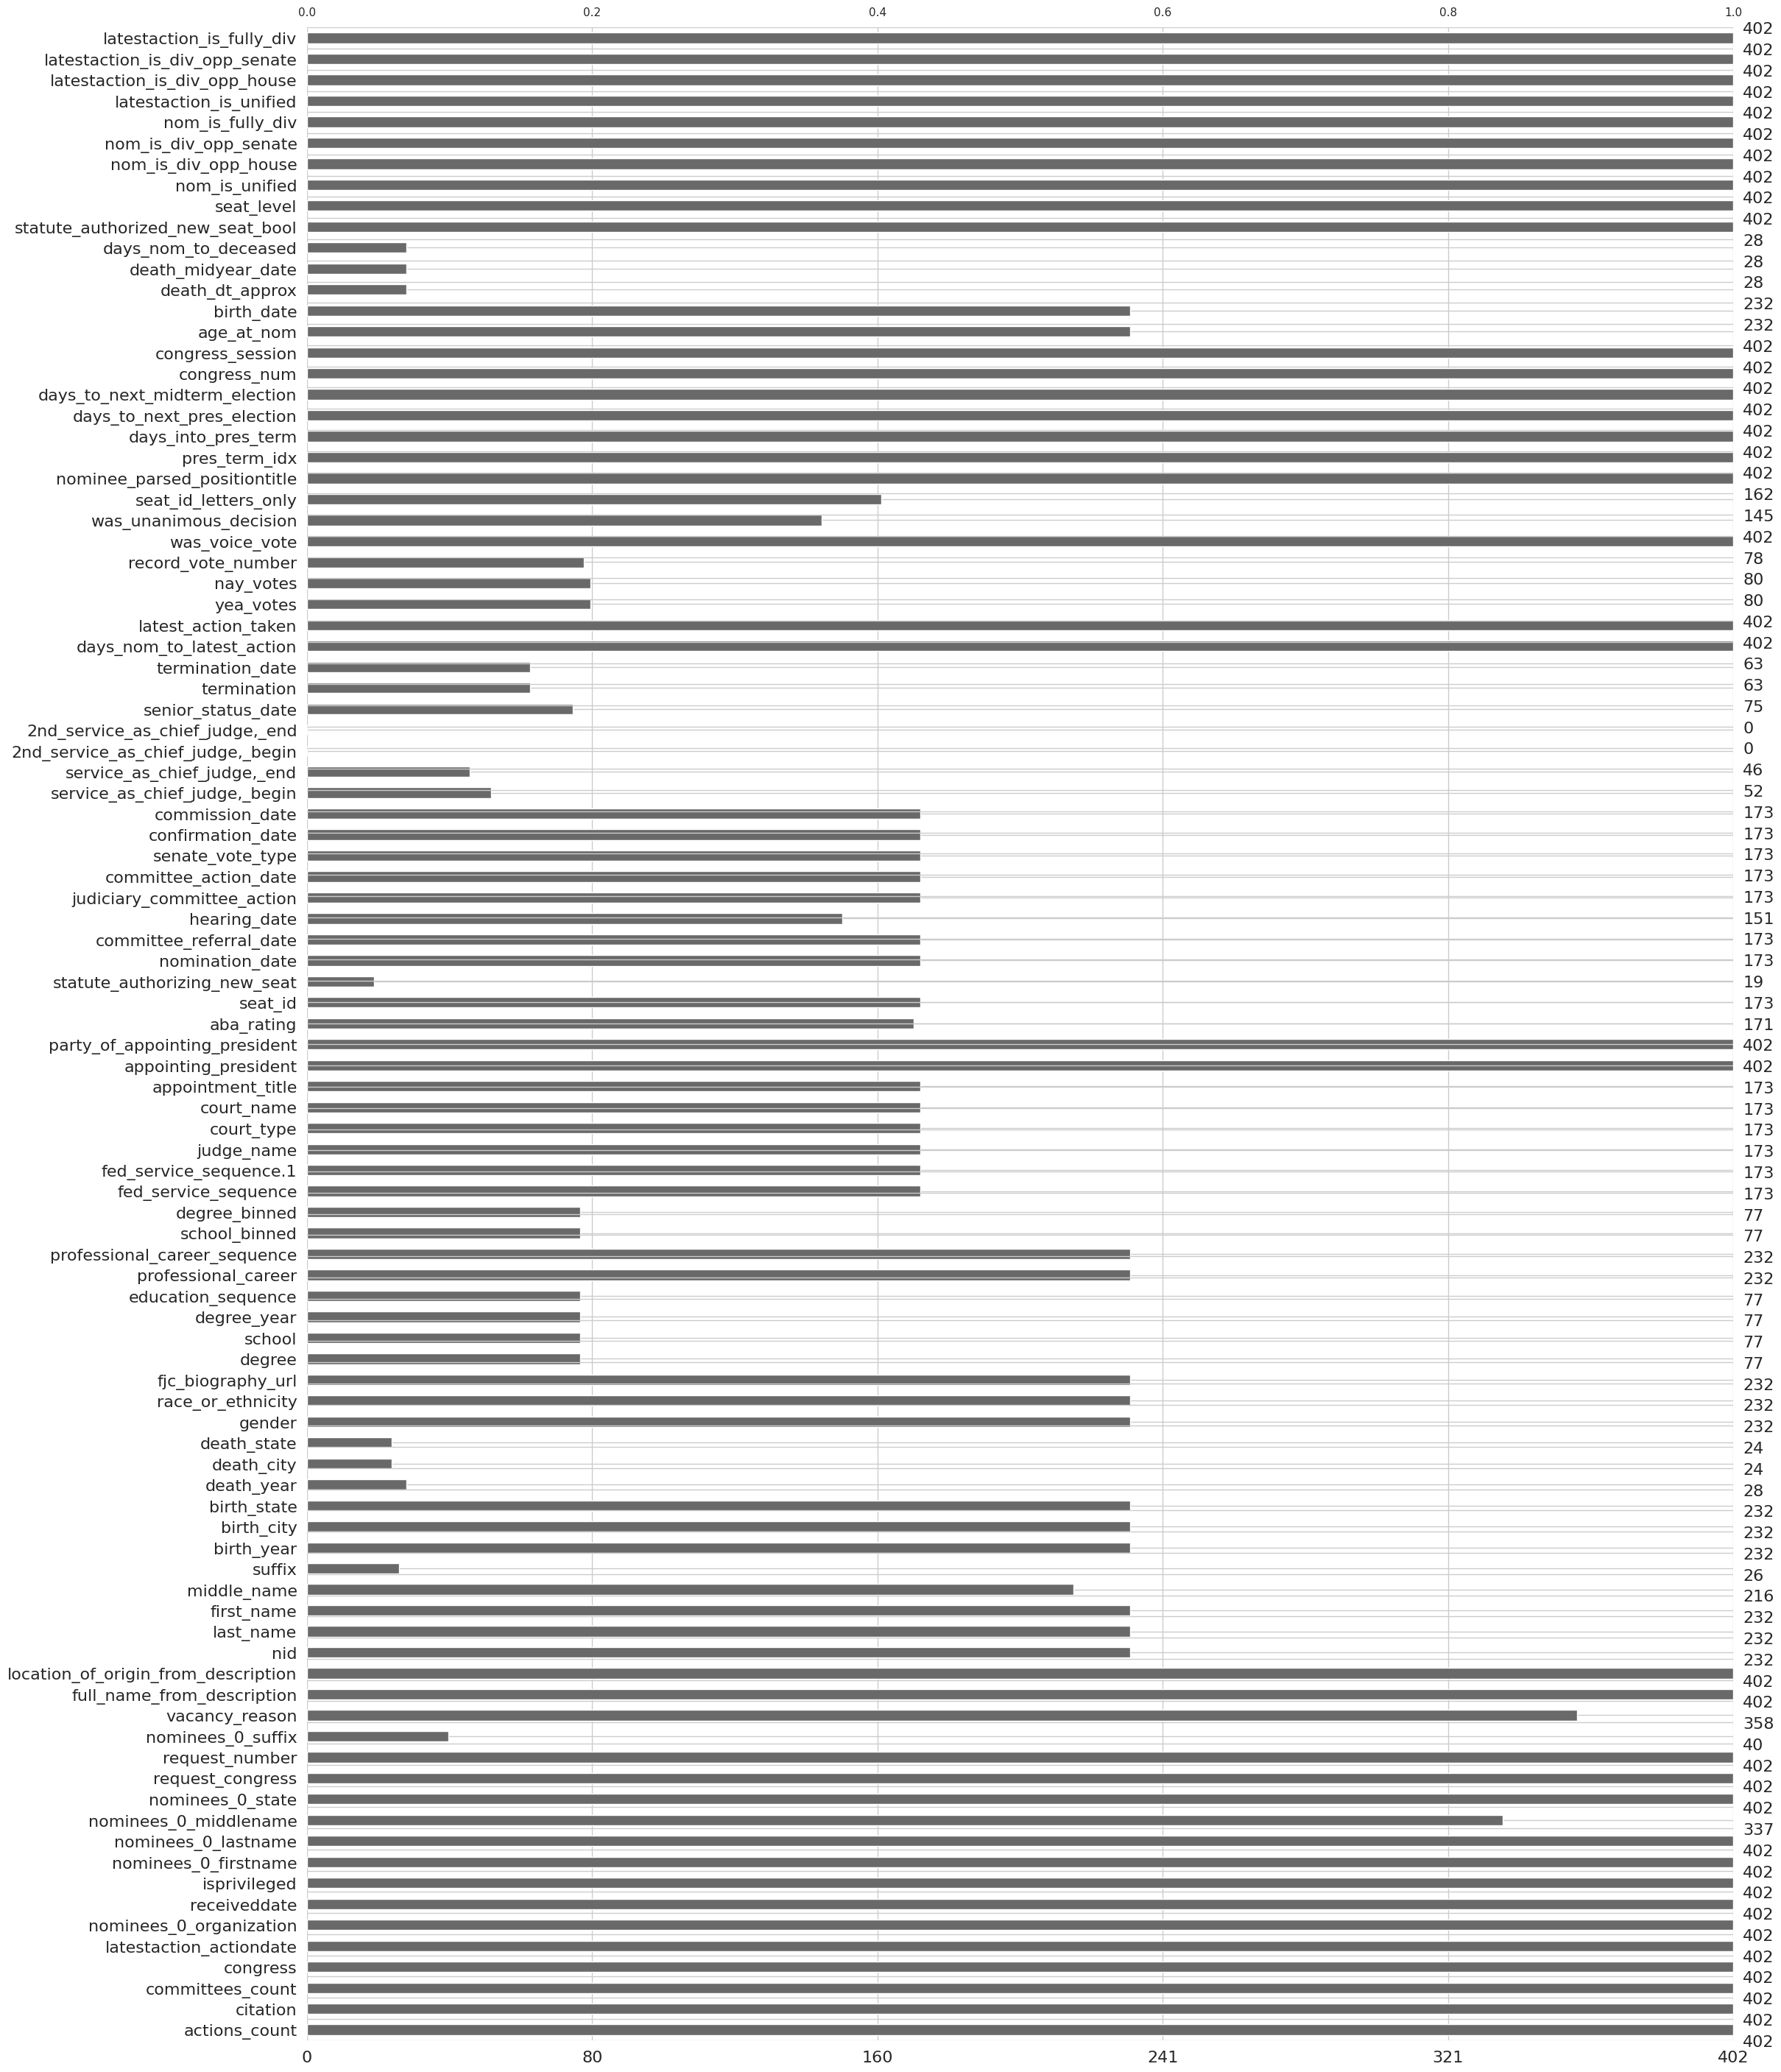

In [ ]:
msno.bar(df.sample(MSNO_SAMPLE_PROPORTION)) # horizontal bar chart indicating for a given sampling of dataframe, how many of those do have data vs. don't

<Axes: >

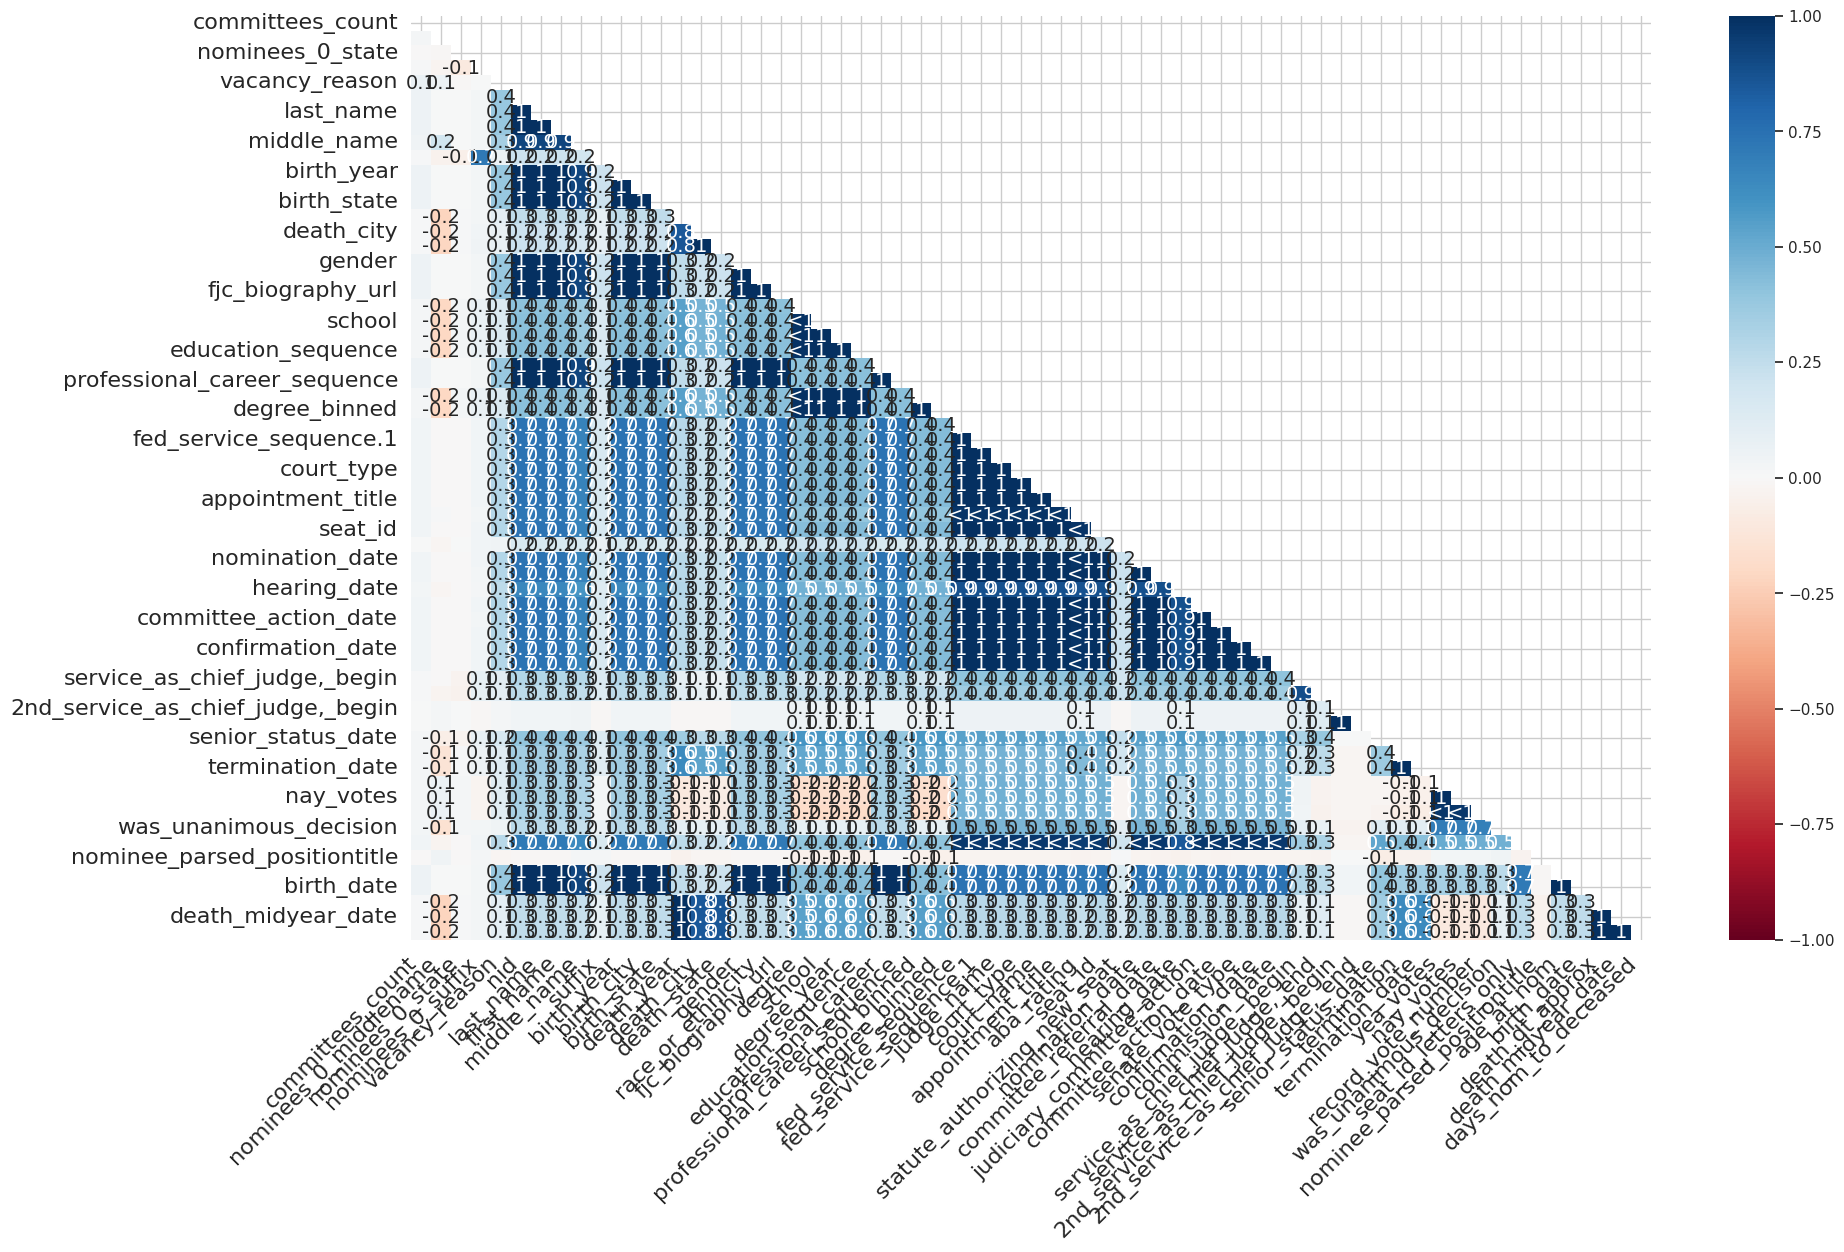

In [ ]:
msno.heatmap(df)

<Axes: >

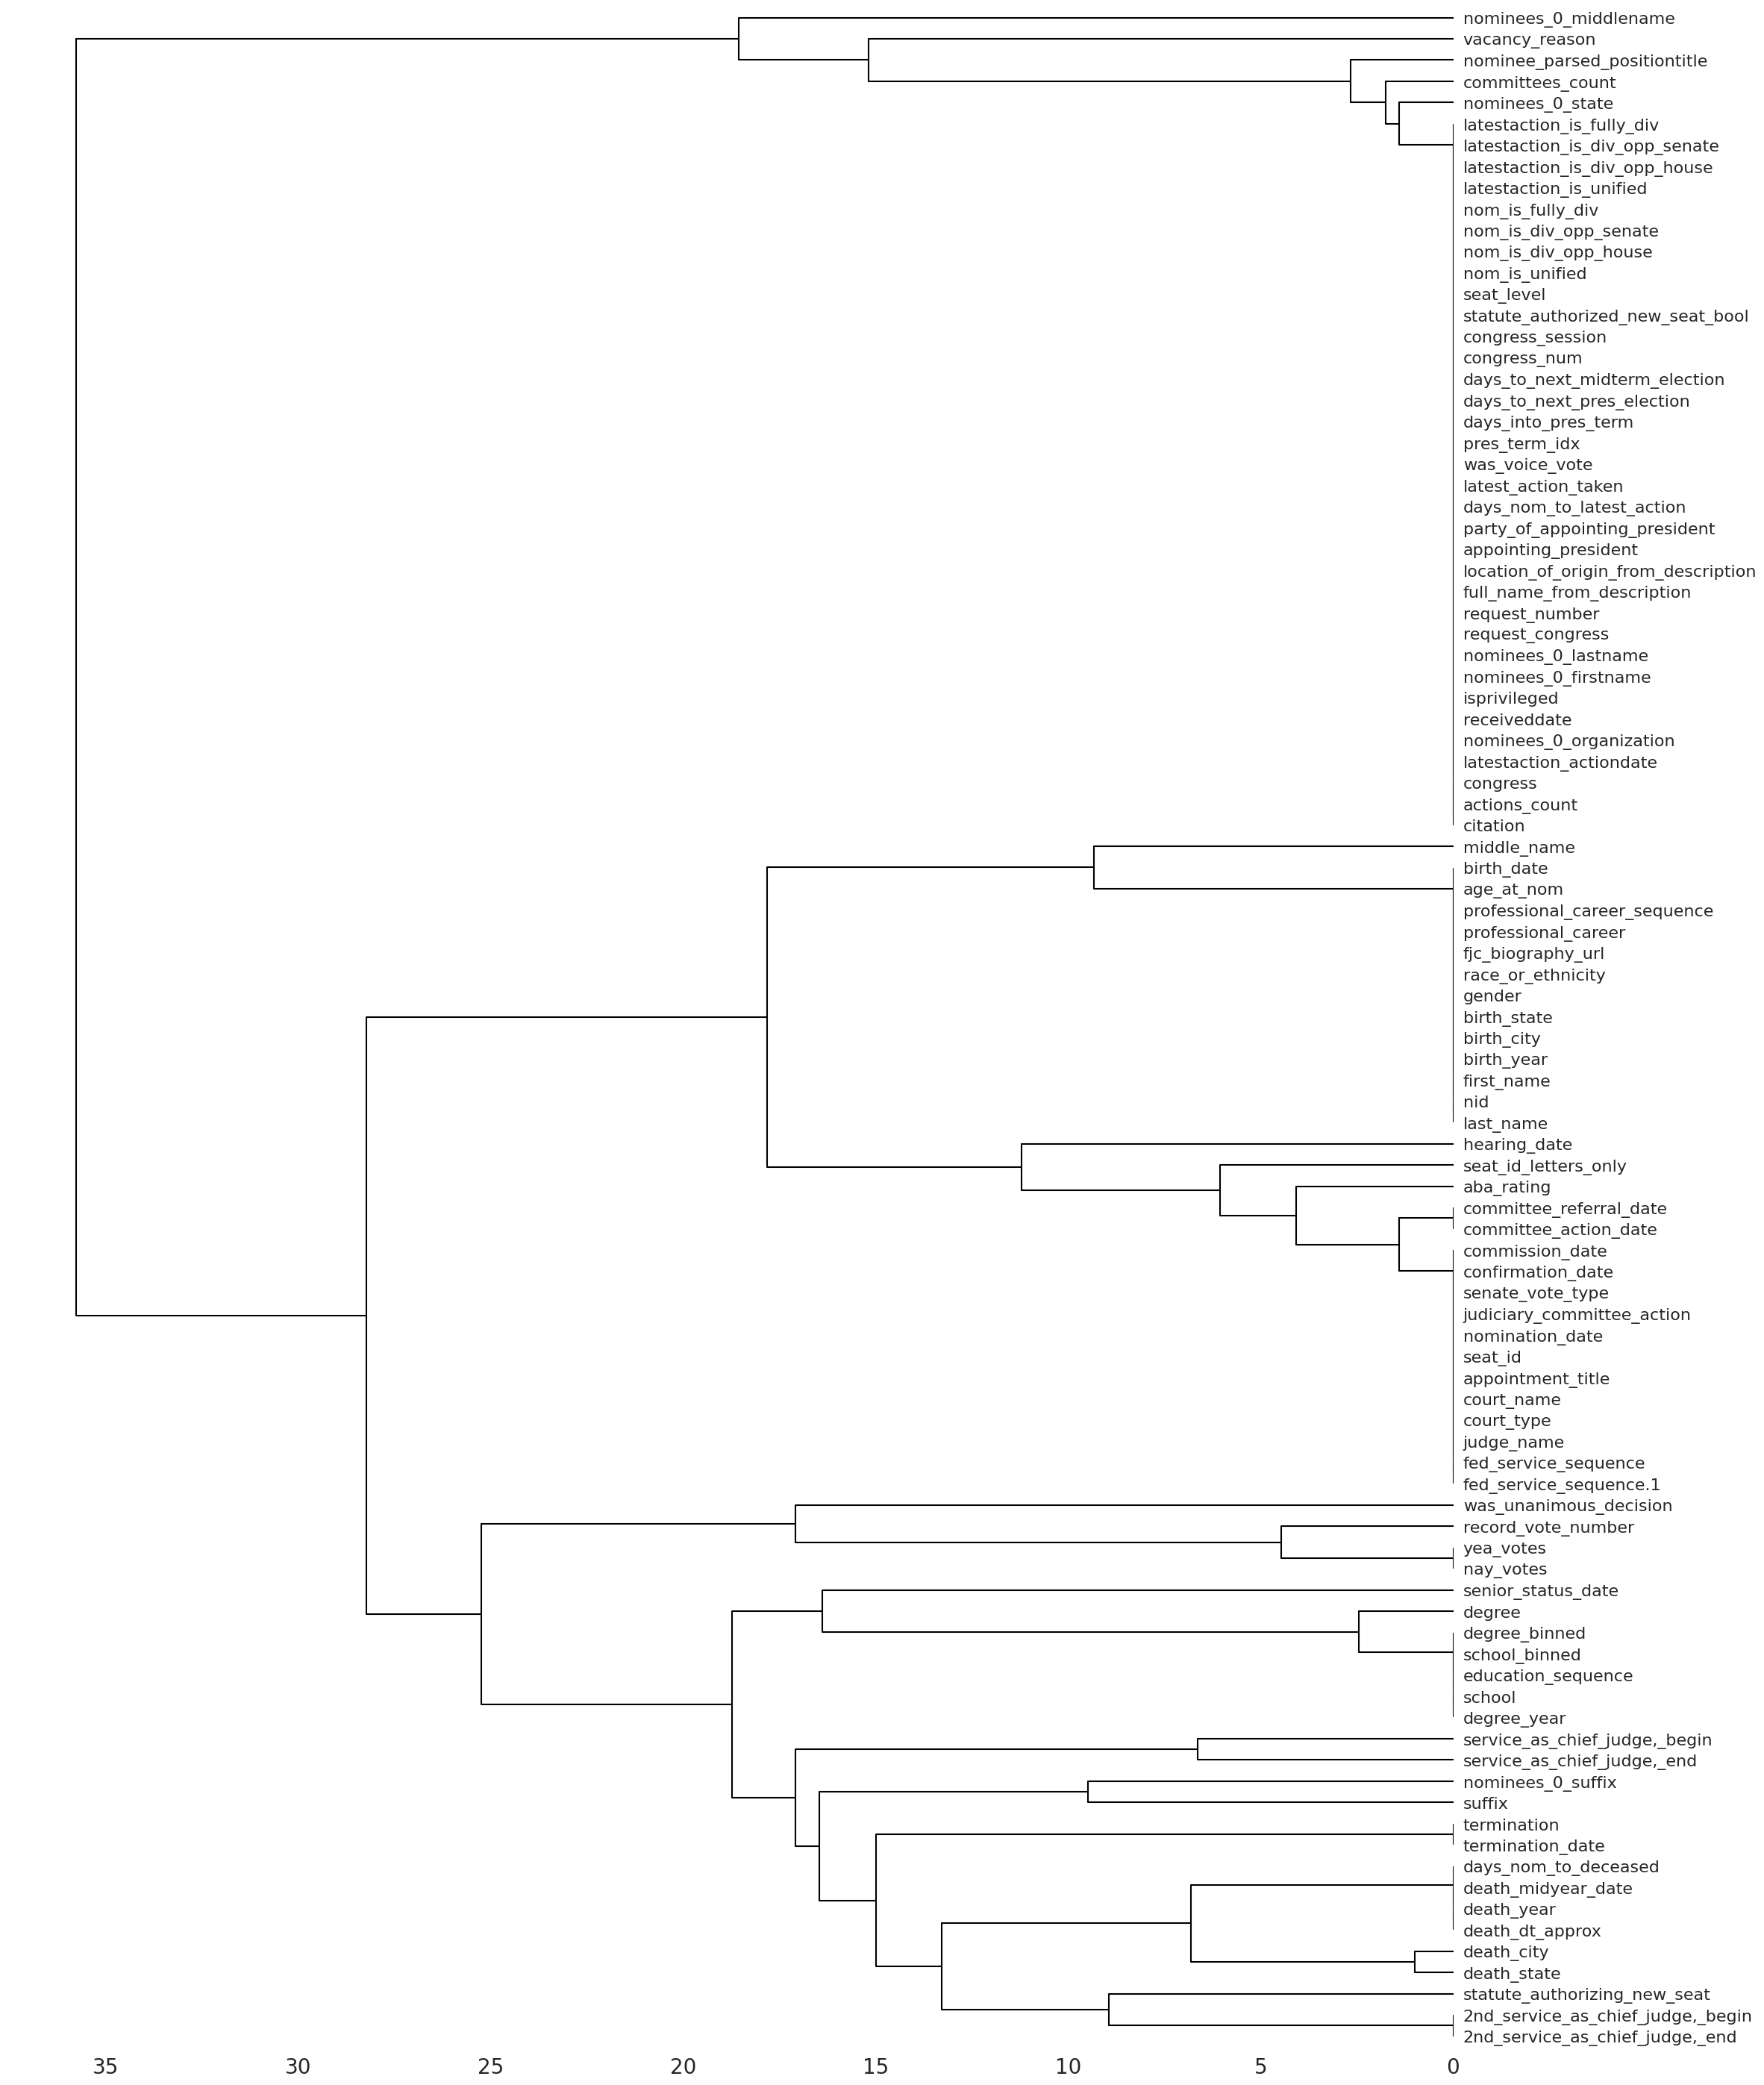

In [ ]:
msno.dendrogram(df)

# Ydata-profiling visualizations

In [ ]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile.to_file("ydata_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/ydata_profiling/model/pandas/describe_date_pandas.py:57: UserWarning: Discarding nonzero nanoseconds in conversion.
  "min": pd.Timestamp.to_pydatetime(series.min()),
/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/ydata_profiling/model/pandas/describe_date_pandas.py:58: UserWarning: Discarding nonzero nanoseconds in conversion.
  "max": pd.Timestamp.to_pydatetime(series.max()),
100%|██████████| 96/96 [00:03<00:00, 30.07it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Analysis of univariate variables

## Categorical Variables

In [ ]:
categorical_variables = [
    "STATE_NAME",
    "Urban_rural_code",
]

## Numeric Variables

# How many actions did it take for the Senate to come to a decision?

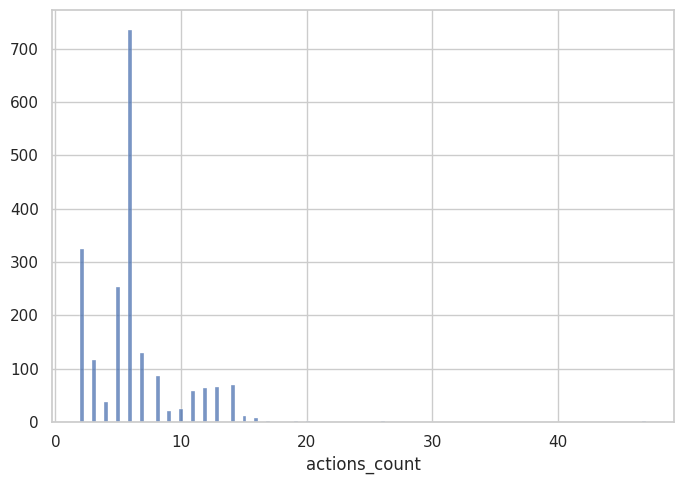

mean actions count:  6.2312282446544005
minimum actions count:  2
maximum actions count:  47


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 1, figsize=(7, 5))

# Create a multiple histogram
sns.histplot(data=df, x="actions_count").set(ylabel=None)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

print("mean actions count: ", df["actions_count"].mean())
print("median actions count: ", df["actions_count"].median())
print("minimum actions count: ", df["actions_count"].min())
print("maximum actions count: ", df["actions_count"].max())

# Analysis of multivariate variables

## Numerical-numerical analysis

## Categorical-categorical analysis

## Numerical-categorical analysis

## Correlation analysis

# Building our model

## Feature Scaling

## Splitting training vs. test data

## Initialization and training

## Parameter tuning

# Stationarity 

The amount of time it's taken for confirmations has generally gotten longer since the start of the data I was able to obtain (ignoring the supreme court line n the chart below becaue there were so few samples of that type, and ignoring the district outlier in 2025 because as we'll see later, it's from a singular person.)

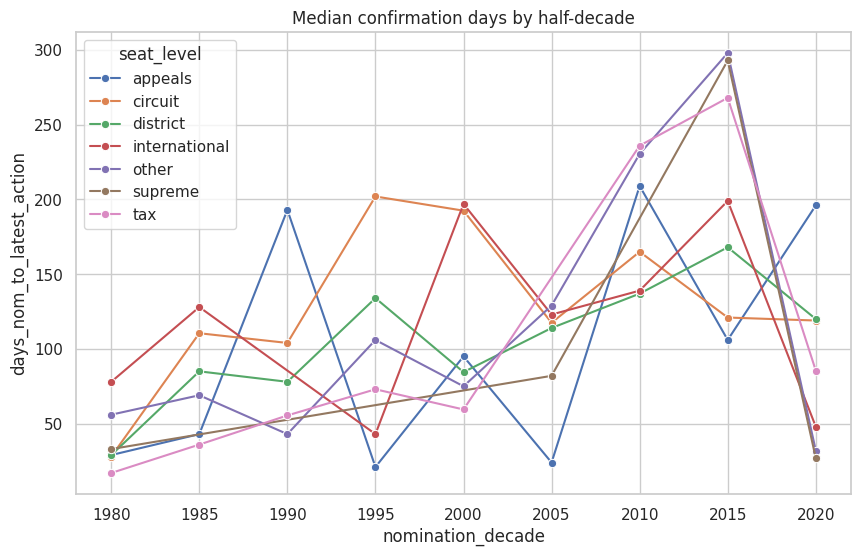

In [ ]:
df['nomination_year'] = pd.to_datetime(df['receiveddate']).dt.year
df['nomination_decade'] = (df['nomination_year'] // 5) * 5
dec_pivot = df[df['days_nom_to_latest_action'].notna()].groupby(['nomination_decade','seat_level'])['days_nom_to_latest_action'].median().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=dec_pivot, x='nomination_decade', y='days_nom_to_latest_action', hue='seat_level', marker='o')
plt.title('Median confirmation days by half-decade')
plt.show()

In [ ]:
df['days_nom_to_latest_action'].describe()

count    2011.000000
mean      135.734460
std       119.271333
min         0.000000
25%        52.500000
50%       103.000000
75%       182.000000
max       727.000000
Name: days_nom_to_latest_action, dtype: float64

/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


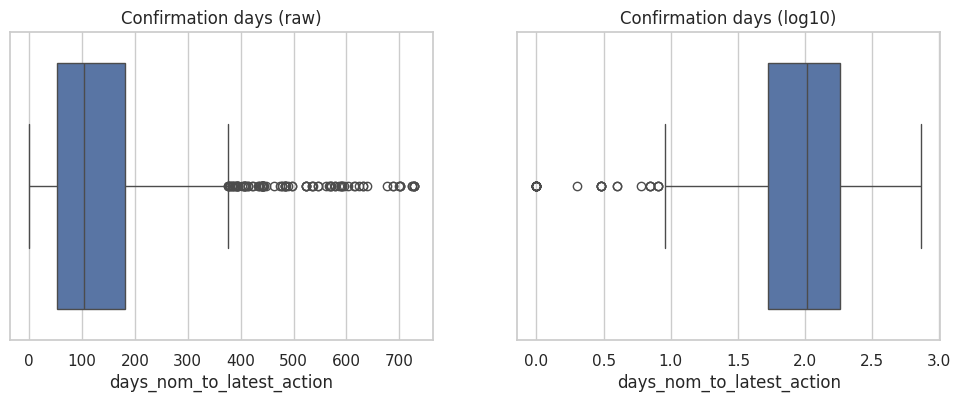

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x=df['days_nom_to_latest_action'], ax=axes[0])
axes[0].set_title('Confirmation days (raw)')
    
sns.boxplot(x=np.log10(df['days_nom_to_latest_action']), ax=axes[1])
axes[1].set_title('Confirmation days (log10)')
plt.show()

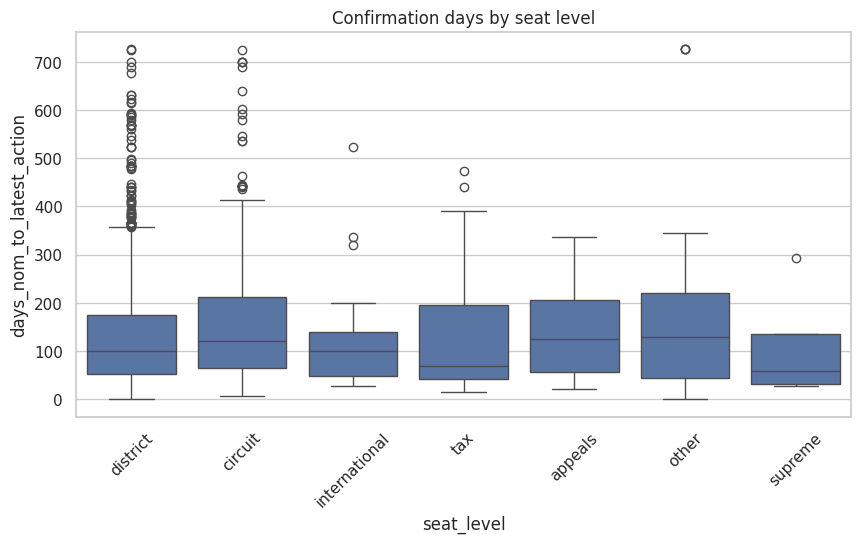

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='seat_level', y='days_nom_to_latest_action')
plt.xticks(rotation=45)
plt.title('Confirmation days by seat level')
plt.show()

## Correlation analyses

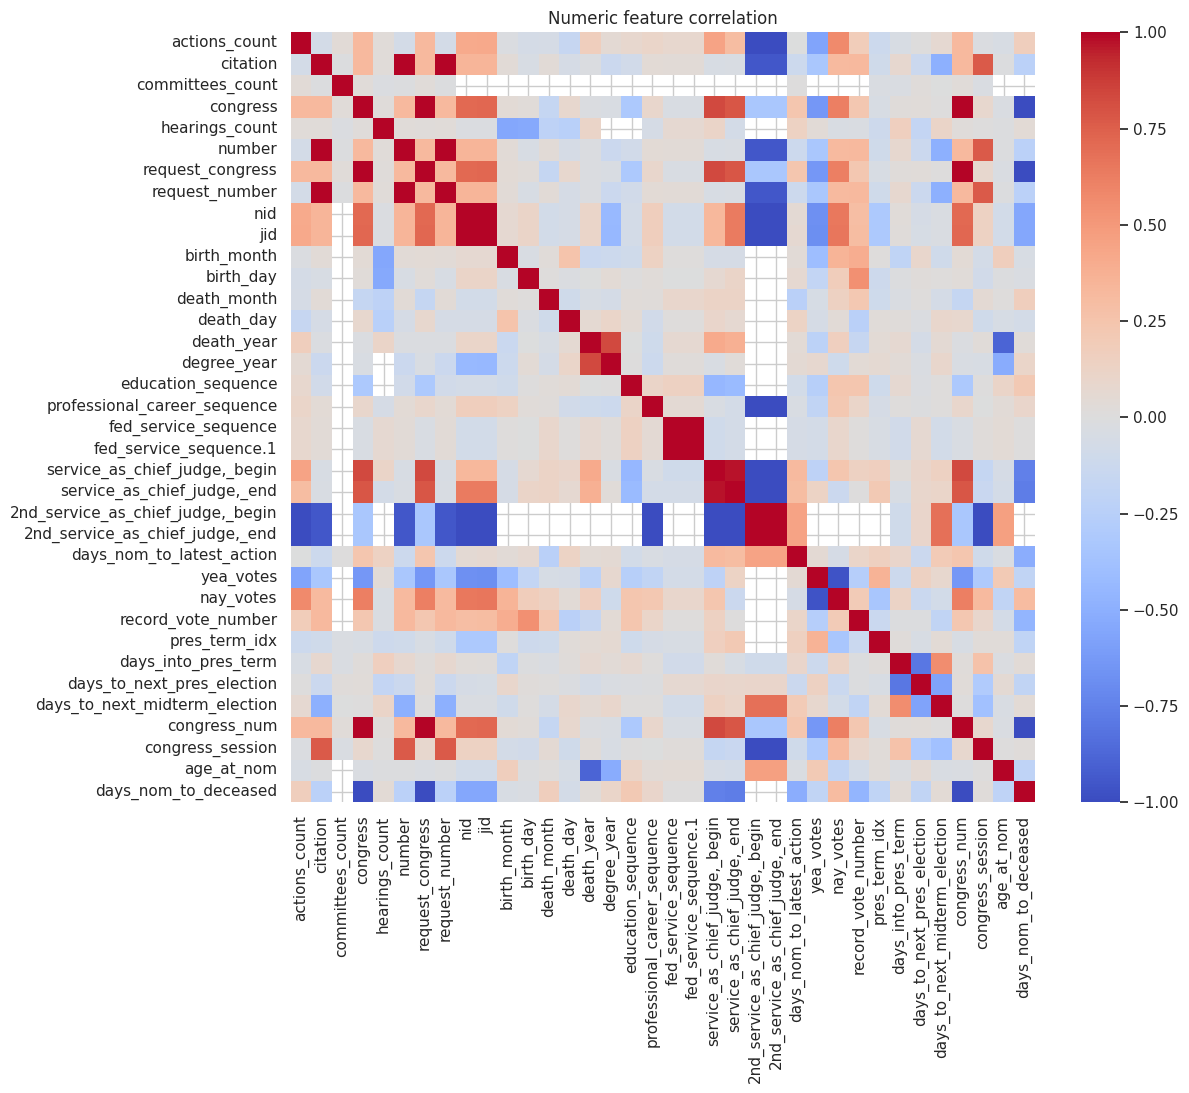

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Numeric feature correlation')
plt.show()

## Simple visualizations


Visualizing seat level distribution:


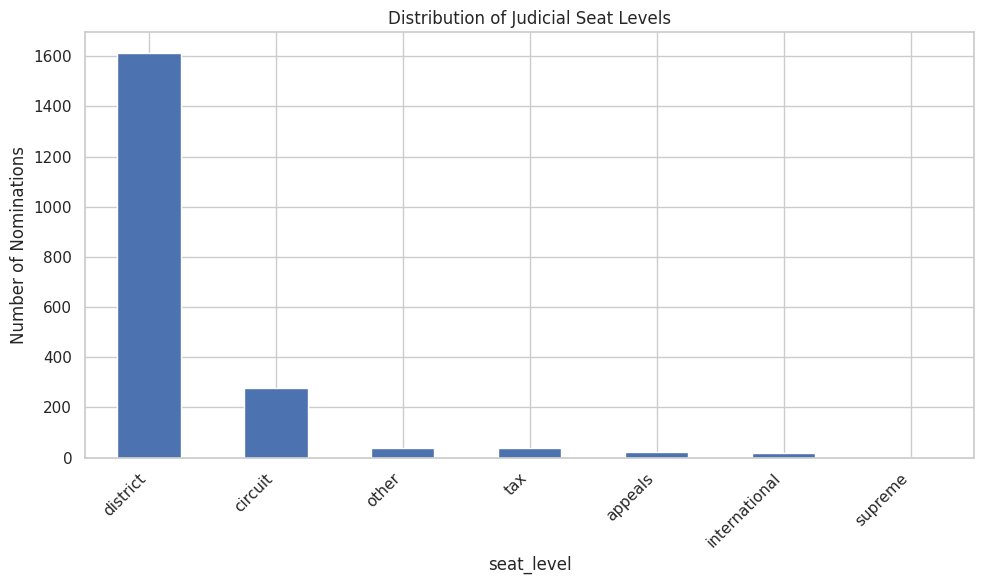

In [ ]:
# Visualization of seat level distribution
print("\nVisualizing seat level distribution:")
import matplotlib.pyplot as plt

df["seat_level"].value_counts().plot(
    kind="bar", 
    figsize=(10, 6), 
    title="Distribution of Judicial Seat Levels"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Nominations")
plt.tight_layout()
plt.show()

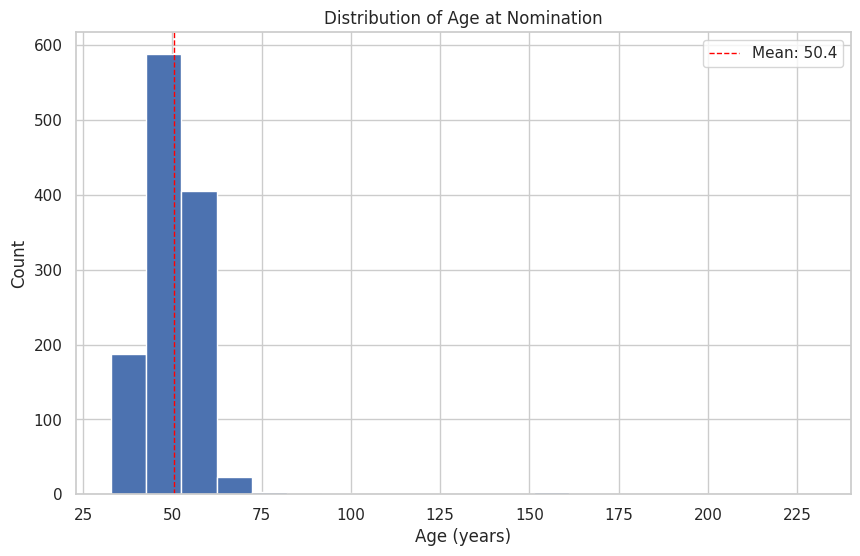

In [ ]:
# visualization of age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['age_at_nom'].hist(bins=20)
plt.title('Distribution of Age at Nomination')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.axvline(df['age_at_nom'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["age_at_nom"].mean():.1f}')
plt.legend()
plt.show()

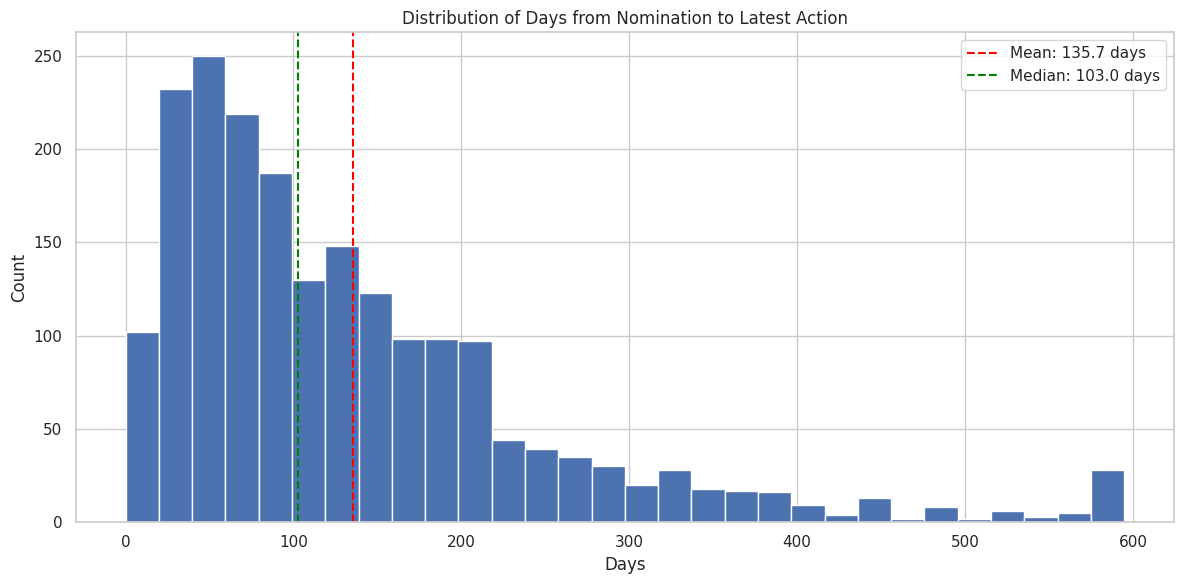

In [ ]:
# days from nomination to last senate action
# Visualization of the distribution
plt.figure(figsize=(12, 6))

# Using clipping to make the histogram more readable (excluding extreme outliers)
days_series = df['days_nom_to_latest_action'].dropna()
q99 = days_series.quantile(0.99)  # 99th percentile

plt.hist(days_series.clip(upper=q99), bins=30)
plt.axvline(days_series.mean(), color='red', linestyle='dashed', 
            label=f'Mean: {days_series.mean():.1f} days')
plt.axvline(days_series.median(), color='green', linestyle='dashed', 
            label=f'Median: {days_series.median():.1f} days')

plt.title('Distribution of Days from Nomination to Latest Action')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show a table of typical durations by outcome
if 'latestaction' in df.columns:
    print("\nMedian days by latest action type:")
    action_days = df.groupby('latestaction')['days_nom_to_latest_action'].median().sort_values()
    for action, days in action_days.items():
        count = df[df['latestaction'] == action].shape[0]
        print(f"- {action}: {days:.1f} days ({count} nominations)")

## Prior rougher attempt

In [ ]:

## pick target and drop rows lacking it
#y = df["days_vac_to_nom"]
#X = df.drop(columns=["days_vac_to_nom",
#                     "days_nom_to_latest_action",     # other targets saved for later tasks
#                     "days_vac_to_conf"])
#
## --------  column groups ------------
#num_cols = [
#    "age_at_nom", "days_into_pres_term",
#    "days_to_next_pres_elec", "days_to_next_mid_elec",
#    "congress_num", "years_private_practice",
#    "highest_degree_level"
#] + [c for c in df.columns if c.startswith("years_")]
#
#bool_cols = [c for c in df.columns if c.startswith("has_")] + ["partisan_mismatch"]
#
#cat_cols = [
#    "pres_term_idx", "congress_session",
#    "seat_level", "vacancy_reason_cat",
#    "pres_party", "party_of_appointing_president"
#]
#
## --------  preprocessors -------------
#preprocessor = ColumnTransformer(
#    transformers=[
#        ("num",  SimpleImputer(strategy="median"), num_cols + bool_cols),
#        ("cat",  OneHotEncoder(handle_unknown="ignore"), cat_cols)
#    ],
#    remainder="drop"
#)
#
## --------  XGBoost regressor ----------
#xgb_reg = xgb.XGBRegressor(
#    n_estimators=600,
#    learning_rate=0.05,
#    max_depth=6,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    objective="reg:squarederror",
#    random_state=42
#)
#
#model = Pipeline(steps=[
#    ("prep", preprocessor),
#    ("xgb",  xgb_reg)
#])
#
## --------  train / validate -----------
#from sklearn.model_selection import cross_val_score, train_test_split
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
#model.fit(X_train, y_train)
#print("Test MAE:", abs(model.predict(X_test) - y_test).mean())